In [ ]:
%pip install itables

In [ ]:
# utilitario para tabelas interativas e download em varios formatos
from itables import init_notebook_mode
import itables.options as opt

init_notebook_mode(all_interactive=True)
opt.buttons = ["copy", "csv", "excel", "pdf"]
opt.classes = ["display", "nowrap"]
opt.scrollY = "400px"       
opt.scrollCollapse = True   
opt.scrollX = True         
opt.paging = False          


In [ ]:
import os
import sys
from IPython.display import display, Markdown
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

root_path = os.path.abspath("..")  
if root_path not in sys.path:
    sys.path.insert(0, root_path)
os.chdir("..")
from experiments.experimentsv3 import Experiment
from config.constants import ACTIVITY_LABELS

X_final_550=pd.read_csv('X_final_550.csv')


In [ ]:
cols_metadata = ['participant_id', 'window_id', 'activity']
col_useless = 'Unnamed: 0'
k = 279
print(f"Shape original: {X_final_550.shape}")
metadata = X_final_550[cols_metadata].copy()

cols_to_drop = cols_metadata + [col_useless]
X_features_only = X_final_550.drop(columns=cols_to_drop, errors='ignore')

top_k_indices = ranking_relieff[:k]
X_selected = X_features_only.iloc[:, top_k_indices]

best_features = pd.concat([metadata, X_selected], axis=1)
best_features.shape

Shape original: (12337, 554)


(12337, 282)

In [ ]:
# set dataset
df_subset = best_features[best_features['activity'] <= 7].copy() ## so as atividades completas
y = df_subset['activity'].values 
subjects = df_subset['participant_id'].values 
cols_to_drop = ['activity', 'participant_id', 'window_id', 'aligned_window_id', 'Unnamed: 0']
drop_actual = [c for c in cols_to_drop if c in df_subset.columns]
X = df_subset.drop(columns=drop_actual).values  

In [14]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from itertools import product
from skrebate import ReliefF

from metrics.metrics import compute_accuracy, compute_f1_score, compute_precision, compute_recall
from data.data_splitting import split_data_kfold

# Função auxiliar de métricas (caso não esteja importada)
def compute_metrics(y_true, y_pred):
    return {
        "Accuracy": compute_accuracy(y_true, y_pred),
        "Recall": compute_recall(y_true, y_pred, average='macro'),
        "Precision": compute_precision(y_true, y_pred, average='macro'),
        "F1": compute_f1_score(y_true, y_pred, average='macro')
    }

# Função auxiliar de split por sujeitos (caso não esteja importada)
def split_subjects_kfold(subjects, n_splits=10, random_state=42):
    unique_subjects = np.unique(subjects)
    n_subjects = len(unique_subjects)
    np.random.seed(random_state)
    shuffled = unique_subjects.copy()
    np.random.shuffle(shuffled)
    folds = []
    fold_size = n_subjects // n_splits
    for i in range(n_splits):
        start_idx = i * fold_size
        if i == n_splits - 1:
            test_subjects = shuffled[start_idx:]
        else:
            test_subjects = shuffled[start_idx:start_idx + fold_size]
        train_subjects = np.setdiff1d(shuffled, test_subjects)
        folds.append((train_subjects, test_subjects))
    return folds



class Experiment:
    def __init__(self, X, y, models, model_parameters, labels=None, subjects=None, scaler=None):
        self.X = np.array(X)
        self.y = np.array(y)
        self.models = models
        self.model_parameters = model_parameters
        self.labels = labels if labels is not None else np.unique(y)
        self.random_state = 10
        self.subjects = np.array(subjects) if subjects is not None else None
        self.subject_aware_mode = (self.subjects is not None)
        self.scaler = scaler  # Scaler (ex: StandardScaler())

        if self.subject_aware_mode:
            unique_subjects = np.unique(self.subjects)
            print(f"{len(unique_subjects)} participantes detectados.")
        
        if self.scaler:
            print(f"Scaler detetado: {type(self.scaler).__name__}")


    def _generate_configs(self, grid):
        keys = list(grid.keys())
        values = list(grid.values())
        for combo in product(*values):
            yield dict(zip(keys, combo))

    def _scale_data(self, X_train, *X_others):
        """Aplica fit no treino e transform nos outros para evitar data leakage."""
        if self.scaler is None:
            return (X_train, *X_others)
        
        sc = copy.deepcopy(self.scaler)
        X_train_scaled = sc.fit_transform(X_train)
        X_others_scaled = [sc.transform(x) for x in X_others]
        return (X_train_scaled, *X_others_scaled)

# -------------------------------------------------------
    # PLOT HISTORY (Corrigido para mostrar F1)
    # -------------------------------------------------------
    def _plot_history(self, history, title):
        if not history: return
        epochs_range = range(1, len(history['train_f1']) + 1)
        
        plt.figure(figsize=(12, 4))
        
        # Gráfico 1: F1 Score (Em vez de Accuracy)
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, history['train_f1'], label='Train F1', color='blue')
        plt.plot(epochs_range, history['val_f1'], label='Val F1', color='orange', linestyle="--")
        
        # Marcar o ponto máximo de validação
        max_val = max(history['val_f1'])
        max_epoch = history['val_f1'].index(max_val) + 1
        plt.scatter(max_epoch, max_val, color='red', zorder=5)
        plt.text(max_epoch, max_val + 0.01, f"{max_val:.3f}", fontsize=9)

        plt.title(f'F1 Score: {title}')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Gráfico 2: Loss
        if history['loss']:
            plt.subplot(1, 2, 2)
            plt.plot(epochs_range, history['loss'], label='Loss', color='red')
            plt.title('Loss Curve')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.grid(True, alpha=0.3)
            
        plt.tight_layout()
        plt.show()

    # -------------------------------------------------------
    # TREINO HÍBRIDO (Corrigido para guardar F1 no histórico)
    # -------------------------------------------------------
    def _train_eval_model(self, model, X_train, y_train, X_val, y_val, epochs=None):
        # MODO PADRÃO (Sem epochs)
        if epochs is None or not hasattr(model, "partial_fit"):
            model.fit(X_train, y_train)
            if X_val is not None and y_val is not None:
                pred_val = model.predict(X_val)
                metrics = compute_metrics(y_val, pred_val)
                return metrics["F1"], model, None 
            return 0.0, model, None

        # MODO ÉPOCAS (MLP com partial_fit)
        all_classes = self.labels
        best_val_f1 = -1
        best_model_state = None
        
        # Agora guardamos F1 em vez de Acc
        history = {'train_f1': [], 'val_f1': [], 'loss': []}
        
        for _ in range(epochs):
            model.partial_fit(X_train, y_train, classes=all_classes)
            
            # 1. Calcular F1 na Validação (Decisão)
            pred_val = model.predict(X_val)
            val_f1 = compute_metrics(y_val, pred_val)["F1"]
            
            # 2. Calcular F1 no Treino (Apenas para o gráfico)
            # Nota: Isto torna o treino ligeiramente mais lento, mas o gráfico fica correto.
            # Se for muito lento, podes usar model.score(X_train, y_train) e mudar a label para Accuracy.
            pred_train = model.predict(X_train)
            train_f1 = compute_metrics(y_train, pred_train)["F1"]
            
            # Guardar histórico
            history['train_f1'].append(train_f1)
            history['val_f1'].append(val_f1)
            
            if hasattr(model, 'loss_'): 
                history['loss'].append(model.loss_)

            # Checkpoint (Guardar melhor modelo com base no F1)
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                best_model_state = copy.deepcopy(model)

        return best_val_f1, best_model_state, history


    def split_tvt_manual(self, train_subjects, val_subjects, test_subjects):
        if not self.subject_aware_mode:
            raise ValueError("Requer subjects!")
        
        train_mask = np.isin(self.subjects, train_subjects)
        val_mask = np.isin(self.subjects, val_subjects)
        test_mask = np.isin(self.subjects, test_subjects)
        
        X_train, y_train = self.X[train_mask], self.y[train_mask]
        X_val, y_val = self.X[val_mask], self.y[val_mask]
        X_test, y_test = self.X[test_mask], self.y[test_mask]
        return X_train, X_val, X_test, y_train, y_val, y_test

    def split_tvt(self, val_size=0.2, test_size=0.2, random_state=0):
        if self.subject_aware_mode:
            unique = np.unique(self.subjects)
            np.random.seed(random_state)
            np.random.shuffle(unique)
            n_test = max(1, int(len(unique) * test_size))
            n_val = max(1, int(len(unique) * val_size))
            test_sub = unique[:n_test]
            val_sub = unique[n_test:n_test+n_val]
            train_sub = unique[n_test+n_val:]
            return self.split_tvt_manual(train_sub, val_sub, test_sub)
        else:
            X_temp, X_test, y_temp, y_test = train_test_split(self.X, self.y, test_size=test_size, stratify=self.y, random_state=random_state)
            val_ratio = val_size / (1 - test_size)
            X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_ratio, stratify=y_temp, random_state=random_state)
            return X_train, X_val, X_test, y_train, y_val, y_test

    # -------------------------------------------------------
    # 1. RUN TRAIN ONLY (Mantido igual)
    # -------------------------------------------------------
    def run_train_only(self):
        results = []
        cms = []
        if self.scaler:
            sc = copy.deepcopy(self.scaler)
            X_proc = sc.fit_transform(self.X)
        else:
            X_proc = self.X

        for name, model in self.models.items():
            param_grid = self.model_parameters.get(name, {})
            for params in self._generate_configs(param_grid):
                model.set_params(**params)
                model.fit(X_proc, self.y)
                pred = model.predict(X_proc)
                metrics = compute_metrics(self.y, pred)
                cm = confusion_matrix(self.y, pred, labels=self.labels)
                results.append({"Model": name, **params, **metrics})
                cms.append(cm)
        return pd.DataFrame(results), cms, np.sum(cms, axis=0)

    # -------------------------------------------------------
    # 2. RUN TRAIN-TEST (MODIFICADO para suportar epochs)
    # -------------------------------------------------------
    def run_train_test(self, test_size=0.3, val_size=0.2, random_state=None, epochs=None):
        """
        TVT simples.
        Se epochs > 0: Usa X_val para monitorizar o treino da MLP (partial_fit).
        Se epochs = None: X_val não é usado para treino, apenas para consistencia.
        """
        if random_state is None: random_state = self.random_state
        
        # 1. Split (Train / Val / Test)
        X_train, X_val, X_test, y_train, y_val, y_test = self.split_tvt(
            val_size=val_size, test_size=test_size, random_state=random_state
        )

        # 2. Scale
        X_train, X_val, X_test = self._scale_data(X_train, X_val, X_test)

        results = []
        cms = []

        for name, model_original in self.models.items():
            param_grid = self.model_parameters.get(name, {})
            for params in self._generate_configs(param_grid):
                model = copy.deepcopy(model_original)
                model.set_params(**params)
                
                print(f"Treinando {name} {params} (Epochs={epochs})...")

                # CHAMA O HELPER INTELIGENTE
                _, best_model, history = self._train_eval_model(
                    model, X_train, y_train, X_val, y_val, epochs=epochs
                )

                # Avaliação final no Teste
                pred = best_model.predict(X_test)
                metrics = compute_metrics(y_test, pred)
                cm = confusion_matrix(y_test, pred, labels=self.labels)
                results.append({"Model": name, **params, **metrics})
                cms.append(cm)

                # Plotar histórico se existir (só para este modelo/config)
                if history:
                    self._plot_history(history, f"{name} {params}")

        return pd.DataFrame(results), cms, np.sum(cms, axis=0)

    # -------------------------------------------------------
    # 3. TVT COM FEATURE SELECTION (MODIFICADO para suportar epochs)
    # -------------------------------------------------------
    def run_tvt_with_feature_selection(self, val_size=0.2, test_size=0.2, 
                                       feature_ranking=None, train_subjects=None,
                                       val_subjects=None, test_subjects=None,
                                       epochs=None): 
        
        # 1. Split
        if train_subjects is not None:
             X_train, X_val, X_test, y_train, y_val, y_test = self.split_tvt_manual(train_subjects, val_subjects, test_subjects)
        else:
             X_train, X_val, X_test, y_train, y_val, y_test = self.split_tvt(val_size=val_size, test_size=test_size)
        
        # 2. Scale
        X_train, X_val, X_test = self._scale_data(X_train, X_val, X_test)

        # 3. ReliefF
        if feature_ranking is None:
            print("⚙️ Calculando ReliefF...")
            relief = ReliefF(n_neighbors=100, n_jobs=-1)
            relief.fit(X_train, y_train)
            ranking = np.argsort(-relief.feature_importances_)
        else:
            ranking = feature_ranking
        
        num_features = X_train.shape[1]
        models_results = []
        
        for name, model_original in self.models.items():
            model_results = {}
            param_grid = self.model_parameters.get(name, {})

            # --- A. Feature Selection Loop ---
            validation_f1s_model = []
            
            # Testa todas as quantidades de features
            for k in range(1, num_features + 1):
                model = copy.deepcopy(model_original)
                sel_feat = ranking[:k]
                
                # Treina (fit ou partial_fit) e devolve a MELHOR performance na validação
                f1_val, _, _ = self._train_eval_model(
                    model, X_train[:, sel_feat], y_train, 
                    X_val[:, sel_feat], y_val, epochs=epochs
                )
                
                validation_f1s_model.append({
                    "model": name, "F1": f1_val, "k_features": k, 
                    "selected_features": sel_feat.tolist()
                })
            
            model_results["validation"] = validation_f1s_model
            
            # Escolhe o melhor k
            f1_vals = [entry['F1'] for entry in validation_f1s_model]
            best_k = validation_f1s_model[np.argmax(f1_vals)]['k_features']
            best_features_indices = ranking[:best_k]
            print(f"   ✓ Melhor k: {best_k} (F1 Val: {max(f1_vals):.4f})")
            
            # --- B. Param Optimization Loop ---
            print(f"   > A otimizar hiperparâmetros com k={best_k}...")
            best_params = None
            best_f1_param = -1
            best_model_trained = None 
            best_history = None
            
            for params in self._generate_configs(param_grid):
                model = copy.deepcopy(model_original)
                model.set_params(**params)
                
                f1, trained_model, history = self._train_eval_model(
                    model, X_train[:, best_features_indices], y_train, 
                    X_val[:, best_features_indices], y_val, epochs=epochs
                )
                
                if f1 > best_f1_param:
                    best_f1_param = f1
                    best_params = params
                    best_model_trained = trained_model
                    best_history = history
            
            models_results.append(model_results)
            # --- C. Final Evaluation ---
            # Testar no conjunto de Teste com o modelo vencedor
            y_test_pred = best_model_trained.predict(X_test[:, best_features_indices])
            metrics_test = compute_metrics(y_test, y_test_pred)
            
            model_results["test"] = {
                "model": name, "F1": metrics_test["F1"], 
                "k_features": best_k, "params": best_params,
                "metrics": metrics_test
            }
            if best_history:
                self._plot_history(best_history, f"{name} (Best: k={best_k})")
        return models_results

    # -------------------------------------------------------
    # 4. CROSS-VALIDATION PADRÃO (Mantido igual)
    # -------------------------------------------------------
    def run_cross_validation(self, n_splits=10, n_repeats=10):
        all_results = []
        cm_stats = {}
        for name, model in self.models.items():
            param_grid = self.model_parameters.get(name, {})
            for params in self._generate_configs(param_grid):
                fold_metrics = {"Accuracy": [], "Recall": [], "Precision": [], "F1": []}
                fold_cms = []
                for repeat in range(n_repeats):
                    if self.subject_aware_mode:
                        folds = split_subjects_kfold(self.subjects, n_splits=n_splits, random_state=self.random_state + repeat)
                    else:
                        folds = split_data_kfold(self.X, n_splits=n_splits, random=repeat)

                    for fold_idx, (train_idx, test_idx) in enumerate(folds):
                        if self.subject_aware_mode:
                            train_mask = np.isin(self.subjects, train_idx)
                            test_mask = np.isin(self.subjects, test_idx)
                            X_train, X_test = self.X[train_mask], self.X[test_mask]
                            y_train, y_test = self.y[train_mask], self.y[test_mask]
                        else:
                            X_train, X_test = self.X[train_idx], self.X[test_idx]
                            y_train, y_test = self.y[train_idx], self.y[test_idx]
                        
                        X_train, X_test = self._scale_data(X_train, X_test)
                        model.set_params(**params)
                        model.fit(X_train, y_train)
                        pred = model.predict(X_test)
                        m = compute_metrics(y_test, pred)
                        cm = confusion_matrix(y_test, pred, labels=self.labels)
                        for k in fold_metrics: fold_metrics[k].append(m[k])
                        fold_cms.append(cm)

                config_result = {
                    "Model": name, **params,
                    "Acc_Mean": np.mean(fold_metrics["Accuracy"]), "Acc_Std": np.std(fold_metrics["Accuracy"]),
                    "F1_Mean": np.mean(fold_metrics["F1"]), "F1_Std": np.std(fold_metrics["F1"])
                }
                all_results.append(config_result)
                cms_array = np.array(fold_cms)
                cm_stats[f"{name}_{str(params)}"] = {
                    "mean": np.mean(cms_array, axis=0),
                    "total": np.sum(cms_array, axis=0)
                }
        return pd.DataFrame(all_results), cm_stats

    # -------------------------------------------------------
    # 5. NESTED CROSS-VALIDATION (Mantido igual)
    # -------------------------------------------------------
    def run_cross_with_validation_feature_selection(self, number_of_folds=10, n_repeats=1, test_size=0.3, feature_ranking=None):
        all_results = []
        for repeat in range(n_repeats):
            print(f"\n[Repetição {repeat+1}/{n_repeats}]")
            cur_rnd = self.random_state + repeat
            if self.subject_aware_mode:
                folds = split_subjects_kfold(self.subjects, n_splits=number_of_folds, random_state=cur_rnd)
            else:
                folds = split_data_kfold(self.X, n_splits=number_of_folds, random=cur_rnd)
            
            for fold_id, fold_data in enumerate(folds):
                print(f"  > Fold {fold_id+1}/{number_of_folds}")
                
                # Setup Outer Split
                if self.subject_aware_mode:
                    train_subj, test_subj = fold_data
                    train_mask = np.isin(self.subjects, train_subj)
                    test_mask = np.isin(self.subjects, test_subj)
                    X_train, X_test = self.X[train_mask], self.X[test_mask]
                    y_train, y_test = self.y[train_mask], self.y[test_mask]
                    
                    # Inner Split (TrS vs Val)
                    uniq_tr = np.unique(self.subjects[train_mask])
                    np.random.shuffle(uniq_tr)
                    n_val = max(1, int(len(uniq_tr) * test_size))
                    val_subj_in = uniq_tr[:n_val]
                    trs_subj_in = uniq_tr[n_val:]
                    trs_mask = np.isin(self.subjects[train_mask], trs_subj_in)
                    val_mask = np.isin(self.subjects[train_mask], val_subj_in)
                    X_TrS, y_TrS = X_train[trs_mask], y_train[trs_mask]
                    X_V, y_V = X_train[val_mask], y_train[val_mask]
                else:
                    train_idx, test_idx = fold_data
                    X_train, X_test = self.X[train_idx], self.X[test_idx]
                    y_train, y_test = self.y[train_idx], self.y[test_idx]
                    X_TrS, X_V, y_TrS, y_V = train_test_split(X_train, y_train, test_size=test_size, stratify=y_train, random_state=cur_rnd)

                # Scaling
                X_TrS_sc, X_V_sc = self._scale_data(X_TrS, X_V)
                X_train_sc, X_test_sc = self._scale_data(X_train, X_test)

                # Feature Selection
                if feature_ranking is None:
                    relief = ReliefF(n_neighbors=100)
                    relief.fit(X_TrS_sc, y_TrS)
                    ranking = np.argsort(-relief.feature_importances_)
                else:
                    ranking = feature_ranking

                num_feat = X_train.shape[1]
                fold_res = {"repetition": repeat, "fold_id": fold_id, "models": []}

                for name, model_orig in self.models.items():
                    param_grid = self.model_parameters.get(name, {})
                    defaults = model_orig.get_params()
                    def_params = {k: defaults.get(k) for k in param_grid.keys()}
                    
                    best_k = 1
                    best_f1_k = -1
                    
                    # Find Best K (Standard fit)
                    for k in range(1, num_feat + 1):
                        model = copy.deepcopy(model_orig)
                        model.set_params(**def_params)
                        sel = ranking[:k]
                        model.fit(X_TrS_sc[:, sel], y_TrS)
                        y_pv = model.predict(X_V_sc[:, sel])
                        f1 = compute_metrics(y_V, y_pv)["F1"]
                        if f1 > best_f1_k:
                            best_f1_k = f1
                            best_k = k
                    
                    best_feats = ranking[:best_k]
                    best_params = def_params
                    best_f1_p = best_f1_k
                    
                    # Find Best Params
                    for p in self._generate_configs(param_grid):
                        model = copy.deepcopy(model_orig)
                        model.set_params(**p)
                        model.fit(X_TrS_sc[:, best_feats], y_TrS)
                        y_pv = model.predict(X_V_sc[:, best_feats])
                        f1 = compute_metrics(y_V, y_pv)["F1"]
                        if f1 > best_f1_p:
                            best_f1_p = f1
                            best_params = p
                    
                    # Final Test
                    final_mod = copy.deepcopy(model_orig)
                    final_mod.set_params(**best_params)
                    final_mod.fit(X_train_sc[:, best_feats], y_train)
                    y_pt = final_mod.predict(X_test_sc[:, best_feats])
                    
                    met = compute_metrics(y_test, y_pt)
                    cm = confusion_matrix(y_test, y_pt, labels=self.labels)
                    fold_res["models"].append({
                        "model_name": name, "best_k": best_k, "best_params": best_params,
                        "test_metrics": met, "cm": cm
                    })
                all_results.append(fold_res)
        return all_results
    

    # -------------------------------------------------------
    # 6. RUN TRAIN-TEST-VALIDATION (Manual Grid Search)
    # -------------------------------------------------------
    def run_train_test_validation(self, val_size=0.2, test_size=0.2, epochs=None,
                                  train_subjects=None, val_subjects=None, test_subjects=None):
        """
        Executa uma Grid Search completa (TVT).
        1. Treina TODAS as combinações de parâmetros no Treino.
        2. Avalia TODAS na Validação (escolhe a melhor).
        3. Avalia APENAS A MELHOR no Teste.
        """
        
        # 1. SPLIT DOS DADOS
        if train_subjects is not None:
            # Opção A: Split Manual
            print(f"Manual Subject Split: Treino={len(train_subjects)}, Val={len(val_subjects)}, Teste={len(test_subjects)}")
            X_train, X_val, X_test, y_train, y_val, y_test = self.split_tvt_manual(
                train_subjects, val_subjects, test_subjects
            )
        else:
            # Opção B: Split Automático
            X_train, X_val, X_test, y_train, y_val, y_test = self.split_tvt(
                val_size=val_size, test_size=test_size
            )

        # 2. SCALING
        X_train, X_val, X_test = self._scale_data(X_train, X_val, X_test)

        validation_history = []  # Guarda TODAS as tentativas
        test_results = []        # Guarda apenas o VENCEDOR de cada modelo
        cms = []                 # Matriz de confusão do vencedor

        # --- 3. Ciclo por Modelo (ex: MLP, SVM...) ---
        for name, model_orig in self.models.items():
            print(f"🔬 A analisar {name}...")
            param_grid = self.model_parameters.get(name, {})
            
            # Variáveis para encontrar o campeão deste modelo
            best_val_f1 = -1.0
            best_params = {}
            best_model_trained = None 
            best_history = None       
            
            # --- 4. Ciclo por Combinação de Parâmetros (Grid Search) ---
            # Aqui é onde ele testa hidden_layer_sizes=(10,), depois (30,), etc.
            print(f"param_grid: {param_grid}")
            for params in self._generate_configs(param_grid):
                print(f"   > Testando parâmetros: {params}...")
                model = copy.deepcopy(model_orig)
                model.set_params(**params)
                
                # Helper treina e avalia na validação
                f1_val, trained_model, history = self._train_eval_model(
                    model, X_train, y_train, X_val, y_val, epochs=epochs
                )
                
                # A. Guardar no Histórico de Validação (Para tu veres que ele testou tudo)
                row_history = {
                    "Model": name,
                    "Params": str(params),
                    "val_F1": f1_val
                }
                validation_history.append(row_history)

                # B. Verificar se é o novo recordista
                if f1_val > best_val_f1:
                    best_val_f1 = f1_val
                    best_params = params
                    best_model_trained = trained_model 
                    best_history = history

            # --- 5. Teste Final (Apenas com o CAMPEÃO) ---
            if best_model_trained is not None:
                # Usamos o modelo campeão para prever no Test Set (dados nunca vistos)
                y_pred_test = best_model_trained.predict(X_test)
                
                metrics_test = compute_metrics(y_test, y_pred_test)
                cm = confusion_matrix(y_test, y_pred_test, labels=self.labels)
                cms.append(cm)

                # C. Guardar Resultado Final
                row_final = {
                    "Model": name,
                    "Best_Params": str(best_params),
                    "Val_Best_F1": best_val_f1,     # Score que o fez ganhar
                    "Test_F1": metrics_test["F1"],  # Score real no teste
                    "Test_Acc": metrics_test["Accuracy"],
                    "Test_Metrics": metrics_test
                }
                test_results.append(row_final)
                
                print(f"   ✓ Vencedor: {best_params} (Val F1: {best_val_f1:.4f} -> Test F1: {metrics_test['F1']:.4f})")

                # Se houver histórico (MLP com epochs), plota o gráfico do vencedor
                if best_history:
                    self._plot_history(best_history, f"{name} (Best Config)")

        return pd.DataFrame(validation_history), pd.DataFrame(test_results), cms

In [ ]:
scaler = StandardScaler()
models = {
    "MultiLayerPerceptron": MLPClassifier(),
}
model_parameters = {
    "MultiLayerPerceptron":{
    "hidden_layer_sizes": [(10,)], # tamanhos variados de camadas ocultas , (30,), (50,), (100,)
    "activation": ['logistic', 'relu', 'tanh'], ## camada de ativação variável

    # --- PARÂMETROS FIXOS
    "solver": ['sgd'],              # Stochastic Gradient Descent (necessário para fixar LR)
    "learning_rate": ['constant'],  # learning rate constante
    "learning_rate_init": [0.01],   # Valor fixo da learning rate
    "batch_size": ['auto'],         # Tamanho do batch
    "random_state": [42]            # Para reprodutibilidade
    }
}

display(Markdown("## Exercise 4.1 - Fixed learning rate"))
sub_train = np.array([9, 11, 0, 13, 5, 8])
sub_val   = np.array([2, 1, 14, 4])
sub_test  = np.array([7, 10, 12, 3, 6])

exp = Experiment(
    X=X, 
    y=y, 
    models=models, 
    model_parameters=model_parameters, 
    subjects=subjects,       # Se tiveres a lista de participantes
    scaler=scaler  # A classe vai usar isto internamente
)


hist, results, cms = exp.run_train_test_validation(
    epochs=100,
    train_subjects=sub_train,
    val_subjects=sub_val,
    test_subjects=sub_test
)



## Exercise 4.1 - Fixed learning rate

Scaler detetado: StandardScaler
Manual Subject Split: Treino=6, Val=4, Teste=5


ValueError: Requer subjects!

## Exercise 4.2 - Variable learning rate

15 participantes detectados.
Scaler detetado: StandardScaler
Manual Subject Split: Treino=4, Val=2, Teste=2
🔬 A analisar MultiLayerPerceptron...
param_grid: {'hidden_layer_sizes': [(10,), (30,), (50,), (100,)], 'activation': ['logistic', 'relu', 'tanh'], 'solver': ['sgd'], 'learning_rate': ['adaptive'], 'learning_rate_init': [0.01, 0.1, 0.001], 'batch_size': ['auto'], 'random_state': [42]}
   > Testando parâmetros: {'hidden_layer_sizes': (10,), 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'batch_size': 'auto', 'random_state': 42}...
   > Testando parâmetros: {'hidden_layer_sizes': (10,), 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'batch_size': 'auto', 'random_state': 42}...
   > Testando parâmetros: {'hidden_layer_sizes': (10,), 'activation': 'logistic', 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'batch_size': 'auto', 'random_state': 42}...
   >

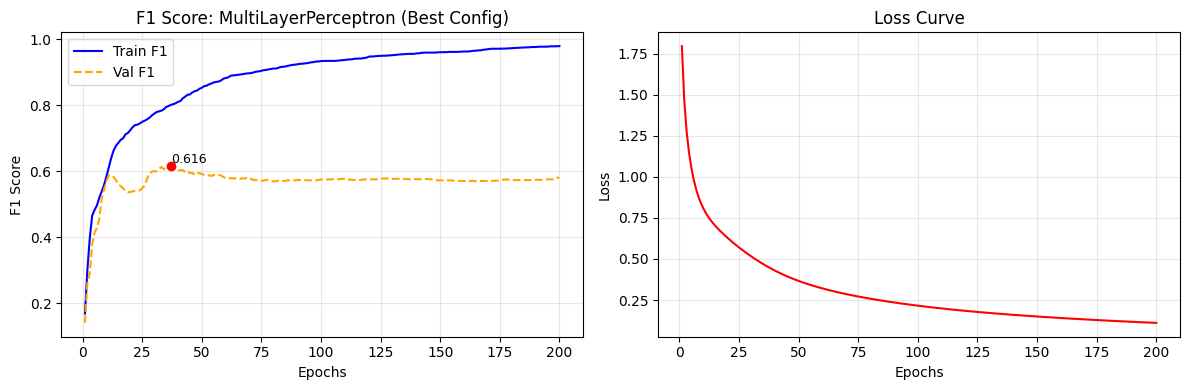

In [20]:
scaler = StandardScaler()
models = {
    "MultiLayerPerceptron": MLPClassifier(),
}
model_parameters = {
    "MultiLayerPerceptron":{
    "hidden_layer_sizes": [(10,), (30,), (50,), (100,)], # tamanhos variados de camadas ocultas
    "activation": ['logistic', 'relu', 'tanh'], ## camada de ativação variável

    # --- PARÂMETROS FIXOS
    "solver": ['sgd'],              
    "learning_rate": ['adaptive'],  
    "learning_rate_init": [0.01,0.1,0.001],   
    "batch_size": ['auto'],         
    "random_state": [42]            
    }
}

display(Markdown("## Exercise 4.2 - Variable learning rate"))
exp = Experiment(
    X=X, 
    y=y, 
    models=models, 
    model_parameters=model_parameters, 
    subjects=subjects,       # Se tiveres a lista de participantes
    scaler=scaler  # A classe vai usar isto internamente
)

train_ids = [1, 3, 5, 7]
val_ids   = [2, 8]
test_ids  = [4, 6]

# Passar as listas explicitamente
hist, results, cms = exp.run_train_test_validation(
    epochs=200,
    train_subjects=train_ids,
    val_subjects=val_ids,
    test_subjects=test_ids
)


## Exercise 4.3 - Variable learning rate

15 participantes detectados.
Scaler detetado: StandardScaler
Manual Subject Split: Treino=4, Val=2, Teste=2
🔬 A analisar MultiLayerPerceptron...
param_grid: {'hidden_layer_sizes': [(5,), (10,)], 'activation': ['logistic', 'relu', 'tanh'], 'momentum': [0.9, 0.95, 0.99], 'solver': ['sgd'], 'learning_rate': ['adaptive'], 'learning_rate_init': [0.01], 'batch_size': ['auto'], 'random_state': [42]}
   > Testando parâmetros: {'hidden_layer_sizes': (5,), 'activation': 'logistic', 'momentum': 0.9, 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'batch_size': 'auto', 'random_state': 42}...
   > Testando parâmetros: {'hidden_layer_sizes': (5,), 'activation': 'logistic', 'momentum': 0.95, 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'batch_size': 'auto', 'random_state': 42}...
   > Testando parâmetros: {'hidden_layer_sizes': (5,), 'activation': 'logistic', 'momentum': 0.99, 'solver': 'sgd', 'learning_rate': 'adaptive', 'learning_rate_init': 0.

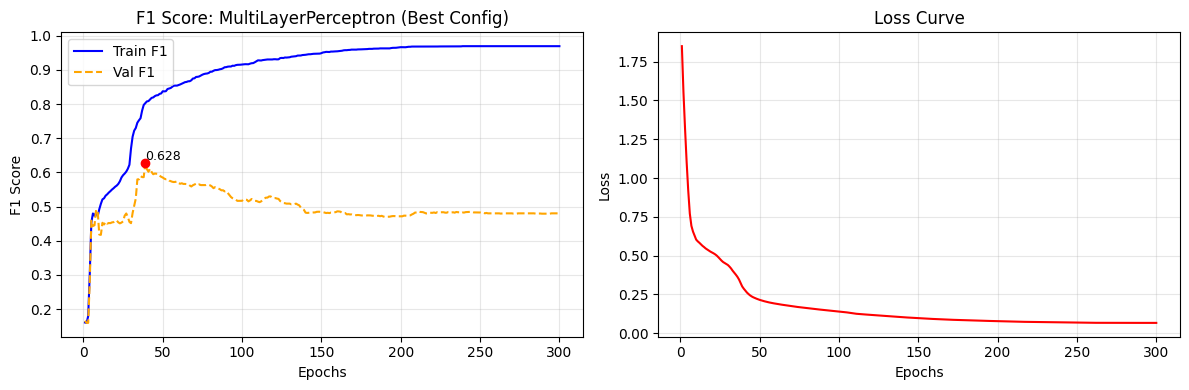

In [16]:
scaler = StandardScaler()
models = {
    "MultiLayerPerceptron": MLPClassifier(),
}
model_parameters = {
    "MultiLayerPerceptron":{
    "hidden_layer_sizes": [(5,),(10,)], # tamanhos variados de camadas ocultas
    "activation": ['logistic', 'relu', 'tanh'], ## camada de ativação variável
    "momentum": [0.9, 0.95, 0.99], ## diferentes valores de momentum
    # --- PARÂMETROS FIXOS
    "solver": ['sgd'],              
    "learning_rate": ['adaptive'],  
    "learning_rate_init": [0.01],   
    "batch_size": ['auto'],         
    "random_state": [42]            
    }
}

display(Markdown("## Exercise 4.3 - Variable learning rate"))
exp = Experiment(
    X=X, 
    y=y, 
    models=models, 
    model_parameters=model_parameters, 
    subjects=subjects,       # Se tiveres a lista de participantes
    scaler=scaler  # A classe vai usar isto internamente
)

train_ids = [1, 3, 5, 7]
val_ids   = [2, 8]
test_ids  = [4, 6]

# Passar as listas explicitamente
hist, results, cms = exp.run_train_test_validation(
    epochs=300,
    train_subjects=train_ids,
    val_subjects=val_ids,
    test_subjects=test_ids
)


In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import OneHotEncoder

class CustomMLP(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_layer_sizes=(50,), learning_rate_init=0.01, epochs=100, random_state=None):
        """
        Args:
            hidden_layer_sizes: Tuplo, ex: (50,) para 50 neurónios na camada escondida.
            learning_rate_init: Velocidade de aprendizagem (alpha).
            epochs: Número de iterações (usado apenas no fit(), ignorado no partial_fit).
            random_state: Seed para inicialização dos pesos.
        """
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate_init = learning_rate_init
        self.epochs = epochs
        self.random_state = random_state
        
        # Variáveis internas da rede
        self.weights1 = None
        self.bias1 = None
        self.weights2 = None
        self.bias2 = None
        self.loss_ = [] # Para compatibilidade com o teu gráfico
        self.is_initialized = False
        self.encoder = None

    def _sigmoid(self, z):
        # Clip para evitar overflow numérico
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def _sigmoid_derivative(self, a):
        return a * (1 - a)

    def _softmax(self, z):
        # Subtrair o máximo para estabilidade numérica
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _initialize_weights(self, n_features, n_classes):
        if self.random_state:
            np.random.seed(self.random_state)
        
        n_hidden = self.hidden_layer_sizes[0] # Assumindo 1 camada escondida
        
        # Inicialização (He/Xavier simplified)
        self.weights1 = np.random.randn(n_features, n_hidden) * 0.1
        self.bias1 = np.zeros((1, n_hidden))
        
        self.weights2 = np.random.randn(n_hidden, n_classes) * 0.1
        self.bias2 = np.zeros((1, n_classes))
        
        self.is_initialized = True

    def partial_fit(self, X, y, classes=None):
        # 1. Preparação (Primeira vez)
        if not self.is_initialized:
            # Precisamos do OneHotEncoder para lidar com y=[1, 2, 1...] -> [[1,0], [0,1]...]
            if classes is None:
                classes = np.unique(y)
            
            self.encoder = OneHotEncoder(categories=[classes], sparse_output=False)
            # Ajustar encoder com as classes conhecidas (mesmo que não estejam neste batch)
            # Criamos um dummy array só para o fit do encoder
            self.encoder.fit(classes.reshape(-1, 1))
            
            n_features = X.shape[1]
            n_classes = len(classes)
            self._initialize_weights(n_features, n_classes)
        
        # Transformar y em One-Hot
        y_encoded = self.encoder.transform(y.reshape(-1, 1))

        # -----------------------------------------------------------
        # A. FORWARD PROPAGATION
        # -----------------------------------------------------------
        # Camada 1 (Input -> Hidden)
        z1 = np.dot(X, self.weights1) + self.bias1
        a1 = self._sigmoid(z1)  # Ativação (usando Sigmoid por simplicidade)

        # Camada 2 (Hidden -> Output)
        z2 = np.dot(a1, self.weights2) + self.bias2
        a2 = self._softmax(z2)  # Saída (Probabilidades)

        # -----------------------------------------------------------
        # B. BACKPROPAGATION
        # -----------------------------------------------------------
        m = X.shape[0] # Número de exemplos

        # Erro na Saída (Predição - Real)
        dz2 = a2 - y_encoded 
        
        # Gradientes da Camada 2
        dw2 = (1 / m) * np.dot(a1.T, dz2)
        db2 = (1 / m) * np.sum(dz2, axis=0, keepdims=True)

        # Erro na Camada Escondida (Retropropagar o erro dz2)
        # Multiplicamos pelo peso e pela derivada da ativação (sigmoid)
        da1 = np.dot(dz2, self.weights2.T)
        dz1 = da1 * self._sigmoid_derivative(a1)

        # Gradientes da Camada 1
        dw1 = (1 / m) * np.dot(X.T, dz1)
        db1 = (1 / m) * np.sum(dz1, axis=0, keepdims=True)

        # -----------------------------------------------------------
        # C. ATUALIZAÇÃO DOS PESOS (Gradient Descent)
        # -----------------------------------------------------------
        self.weights2 -= self.learning_rate_init * dw2
        self.bias2    -= self.learning_rate_init * db2
        self.weights1 -= self.learning_rate_init * dw1
        self.bias1    -= self.learning_rate_init * db1

        # -----------------------------------------------------------
        # D. CÁLCULO DA LOSS (Cross-Entropy)
        # -----------------------------------------------------------
        # Evitar log(0)
        epsilon = 1e-15
        a2_clipped = np.clip(a2, epsilon, 1 - epsilon)
        loss = -np.mean(np.sum(y_encoded * np.log(a2_clipped), axis=1))
        self.loss_ = loss # A tua classe Experiment procura este atributo para o gráfico!
        
        return self

    def fit(self, X, y):
        """Fit padrão (treina todas as épocas de uma vez)"""
        self.loss_history = []
        classes = np.unique(y)
        
        for _ in range(self.epochs):
            self.partial_fit(X, y, classes=classes)
            self.loss_history.append(self.loss_)
        return self

    def predict(self, X):
        # Forward pass simples para obter a classe final
        z1 = np.dot(X, self.weights1) + self.bias1
        a1 = self._sigmoid(z1)
        z2 = np.dot(a1, self.weights2) + self.bias2
        a2 = self._softmax(z2)
        
        # Retorna o índice da maior probabilidade convertido para a classe original
        indices = np.argmax(a2, axis=1)
        return self.encoder.categories_[0][indices]

    def score(self, X, y):
        # Necessário para a tua função _train_eval_model calcular acc no histórico
        from sklearn.metrics import accuracy_score
        return accuracy_score(y, self.predict(X))

## Neural Network From Scratch (NumPy Only)

15 participantes detectados.
Scaler detetado: StandardScaler
🔬 A analisar Custom_MLP...
param_grid: {'hidden_layer_sizes': [(10,), (30,), (50,)], 'learning_rate_init': [0.01, 0.1], 'random_state': [42]}
   > Testando parâmetros: {'hidden_layer_sizes': (10,), 'learning_rate_init': 0.01, 'random_state': 42}...
   > Testando parâmetros: {'hidden_layer_sizes': (10,), 'learning_rate_init': 0.1, 'random_state': 42}...
   > Testando parâmetros: {'hidden_layer_sizes': (30,), 'learning_rate_init': 0.01, 'random_state': 42}...
   > Testando parâmetros: {'hidden_layer_sizes': (30,), 'learning_rate_init': 0.1, 'random_state': 42}...
   > Testando parâmetros: {'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'random_state': 42}...
   > Testando parâmetros: {'hidden_layer_sizes': (50,), 'learning_rate_init': 0.1, 'random_state': 42}...
   ✓ Vencedor: {'hidden_layer_sizes': (50,), 'learning_rate_init': 0.1, 'random_state': 42} (Val F1: 0.5932 -> Test F1: 0.5876)


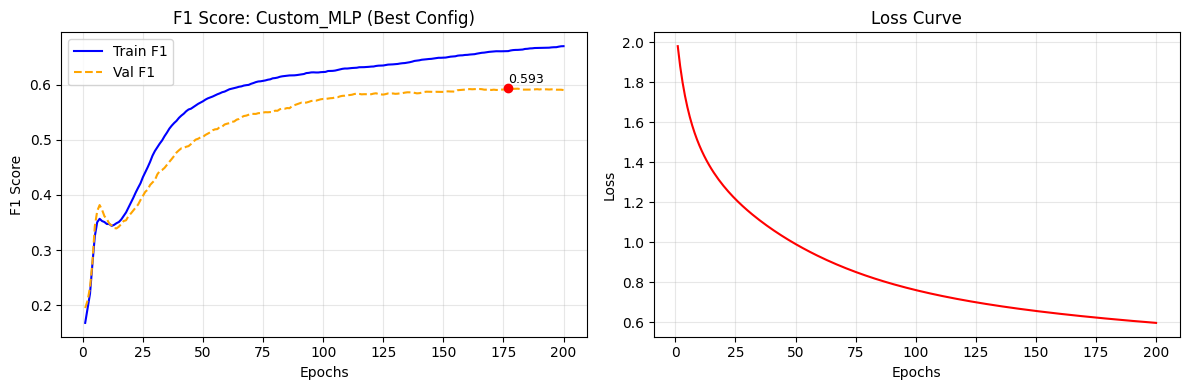

### 1. Histórico (Validação)

Loading ITables v2.6.1 from the init_notebook_mode cell... (need help?)


### 2. Resultado Final

Loading ITables v2.6.1 from the init_notebook_mode cell... (need help?)


In [19]:
# ==============================================================================
# CONFIGURAÇÃO COM REDE NEURONAL "FROM SCRATCH"
# ==============================================================================

# 1. Definir Modelo
models_scratch = {
    "Custom_MLP": CustomMLP() 
}

# 2. Definir Parâmetros
# Nota: Usamos as mesmas chaves porque defini a classe para aceitar os mesmos nomes
model_parameters_scratch = {
    "Custom_MLP": {
        # Variar número de neurónios
        "hidden_layer_sizes": [(10,), (30,), (50,)], 
        
        # A nossa classe personalizada só tem Learning Rate Fixa (implementada no partial_fit)
        "learning_rate_init": [0.01, 0.1], 
        
        # seed
        "random_state": [42]
    }
}

display(Markdown("## Neural Network From Scratch (NumPy Only)"))

# 3. Instanciar Experiência
# Usamos o mesmo Experiment que definiste antes!
exp_scratch = Experiment(
    X=X, 
    y=y, 
    models=models_scratch, 
    model_parameters=model_parameters_scratch, 
    subjects=subjects, 
    scaler=scaler # Continua a ser crucial normalizar
)

# 4. Executar
# Podes usar epochs=200 para veres o gráfico de evolução
# Como implementámos o 'partial_fit' na CustomMLP, isto vai funcionar!
val_hist_scratch, test_res_scratch, cms_scratch = exp_scratch.run_train_test_validation(
    val_size=0.2, 
    test_size=0.2,
    epochs=200 
)

# 5. Resultados
display(Markdown("### 1. Histórico (Validação)"))
display(val_hist_scratch.sort_values(by="val_F1", ascending=False).head())

display(Markdown("### 2. Resultado Final"))
display(test_res_scratch)